In [2]:
import os
import random
import sys
import argparse


# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim


# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, Resize, Normalize
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import multiprocessing
from tqdm.auto import tqdm

#from models import Model
#from datasets import get_data_loaders
#from train import train
#from test import evaluate, load_model

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.5.1
0.20.1


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


### Preparing and loading the datset 

In [4]:
train_dir = "D:/sp_cup/dataset/train"
valid_dir = "D:/sp_cup/dataset/valid"

train_real = len(os.listdir(f"{train_dir}/real"))
train_fake = len(os.listdir(f"{train_dir}/fake"))
valid_real = len(os.listdir(f"{valid_dir}/real"))
valid_fake = len(os.listdir(f"{valid_dir}/fake"))

print(f"Training dataset size: {train_real + train_fake} (Real: {train_real}, Fake: {train_fake})")
print(f"Validation dataset size: {valid_real + valid_fake} (Real: {valid_real}, Fake: {valid_fake})")

Training dataset size: 262160 (Real: 42690, Fake: 219470)
Validation dataset size: 3072 (Real: 1548, Fake: 1524)


#### Calculate mean and std of the dataset

In [5]:

# Compute mean and std of the dataset
def compute_mean_and_std(data_dir):
    """
    Compute per-channel mean and std of the dataset (to be used in transforms.Normalize())
    """

    cache_file = "logs/mean_and_std.pt"
    if os.path.exists(cache_file):
        print(f"Reusing cached mean and std")
        d = torch.load(cache_file)

        return d["mean"], d["std"]

    ds = datasets.ImageFolder(
        data_dir, transform=transforms.Compose([transforms.ToTensor()])
    )
    dl = torch.utils.data.DataLoader(
        ds, batch_size=1, num_workers=multiprocessing.cpu_count()
    )

    mean = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing mean", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean = mean / len(dl.dataset)

    var = 0.0
    npix = 0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing std", ncols=80):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1)) ** 2).sum([0, 2])
        npix += images.nelement()

    std = torch.sqrt(var / (npix / 3))

    # Cache results so we don't need to redo the computation
    torch.save({"mean": mean, "std": std}, cache_file)

    return mean, std


In [6]:
# training_mean, training_std = compute_mean_and_std(train_dir)

In [7]:
# print(f"Training Mean: {training_mean}, Training Std: {training_std}")

In [8]:
def get_data_loaders(train_dir, test_dir, batch_size, transform=None):
    """
    Create train and test data loaders using torchvision.datasets.ImageFolder.
    """

    # Create datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    # Create DataLoaders for train and test datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [9]:
BATCH_SIZE = 16

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get data loaders

train_loader, valid_loader = get_data_loaders(train_dir=train_dir,
                                              test_dir=valid_dir, 
                                              batch_size=BATCH_SIZE,
                                              transform=transform)


In [10]:
print(len(train_loader), len(valid_loader))
print(next(iter(train_loader))[0].shape)
print(next(iter(valid_loader))[0].shape)

16385 192
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


In [11]:
train_features_batch, train_labels_batch = next(iter(train_loader))

print(train_features_batch.shape, train_labels_batch.shape)
print(train_labels_batch)
print(['Fake' if label == 0 else 'Real' for label in train_labels_batch])

torch.Size([16, 3, 224, 224]) torch.Size([16])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
['Fake', 'Fake', 'Fake', 'Fake', 'Real', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Real', 'Fake', 'Fake', 'Fake', 'Fake']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3340336..1.6073294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.2274075].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6967788].


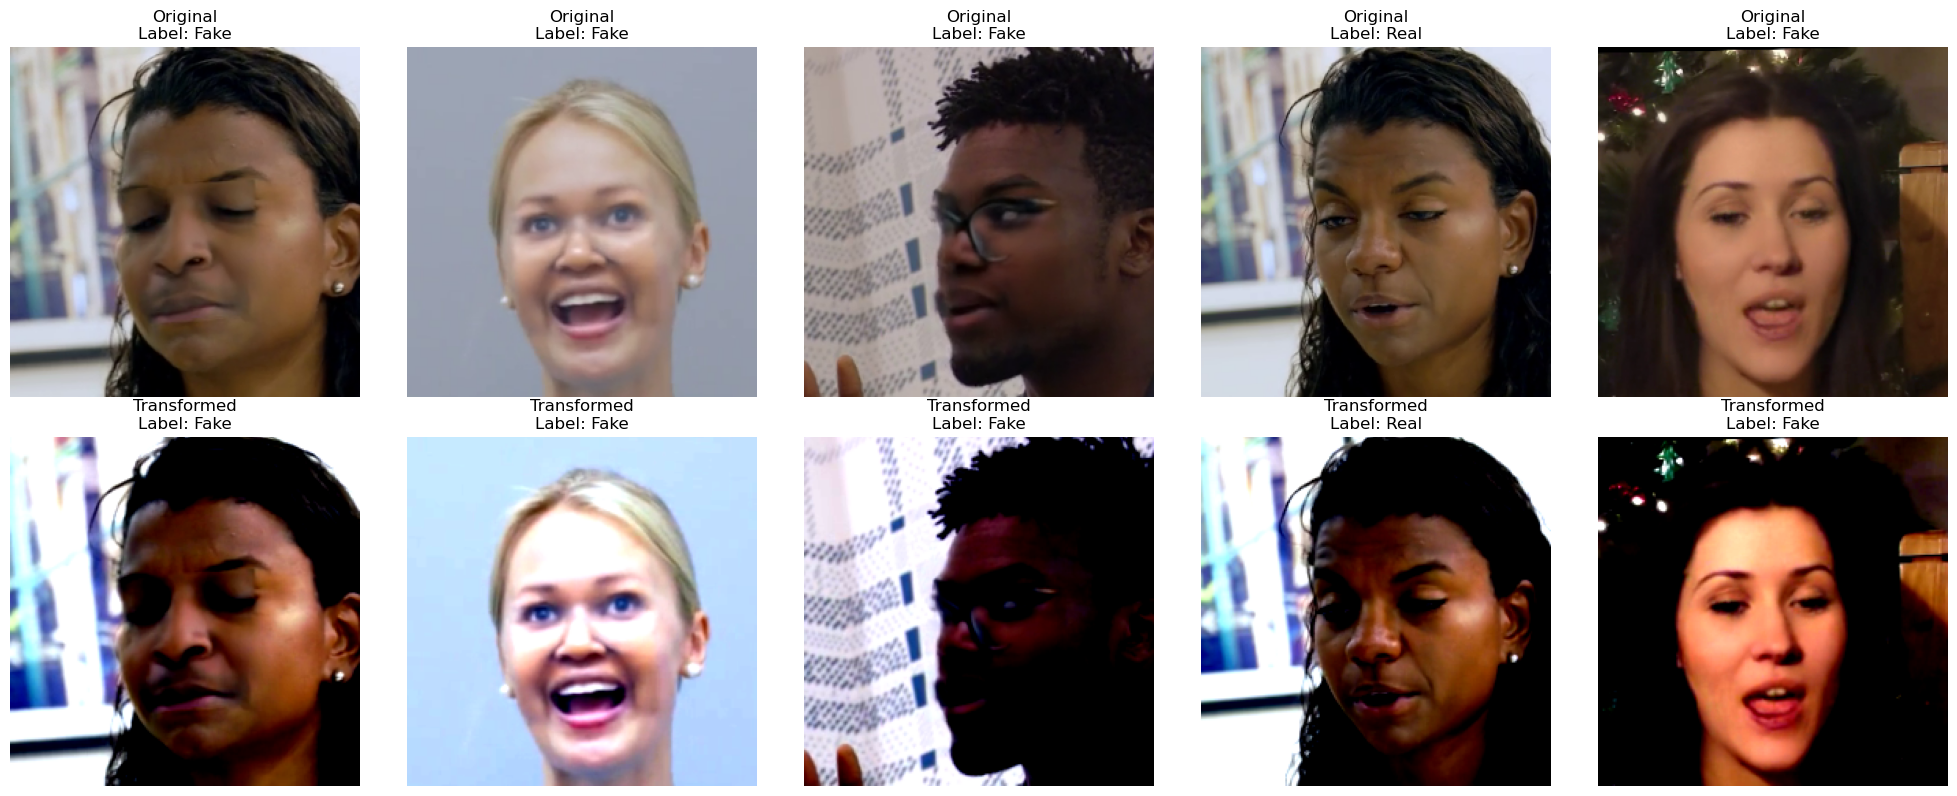

In [12]:
train_dataset = datasets.ImageFolder(train_dir, transform=None)
test_dataset = datasets.ImageFolder(valid_dir, transform=None)

# Randomly select 5 images from the balanced dataset
selected_indices = random.sample(range(len(train_dataset)), 5)

# Display 5 images before and after transform
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns

for i, idx in enumerate(selected_indices):
    image, label = train_dataset[idx]
    image = image.convert("RGB")
    
    # Display original image
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Original\nLabel: {'Fake' if label == 0 else 'Real'}")
    axes[0, i].axis('off')  # Hide the axis

    # Apply transform and display transformed image
    transformed_image = transform(image)
    axes[1, i].imshow(transformed_image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize the image
    axes[1, i].set_title(f"Transformed\nLabel: {'Fake' if label == 0 else 'Real'}")
    axes[1, i].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

### Model

In [13]:
class FrequencyBranch(nn.Module):
    def __init__(self, output_size=128, hidden_size1=512, hidden_size2=256):
        super(FrequencyBranch, self).__init__()
        # Recalculate input size for single sample (without batch dimension)
        input_size = 3 * 224 * 224 * 2  # 128x128 pixels, 2 features (amplitude and phase)
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, img):
        # img shape: [batch_size, channels, height, width]
        batch_size = img.shape[0]
        
        # Move to CPU for numpy operations
        img_np = img.cpu().numpy()
        
        # Process each image in the batch
        batch_features = []
        for i in range(batch_size):
            # Apply FFT to single image
            f_transform = np.fft.fft2(img_np[i])
            f_transform_shifted = np.fft.fftshift(f_transform)
            amplitude = np.abs(f_transform_shifted)
            phase = np.angle(f_transform_shifted)
            
            # Concatenate amplitude and phase
            features = np.concatenate((amplitude.flatten(), phase.flatten()))
            batch_features.append(features)
            
        # Stack all features into a batch
        batch_features = np.stack(batch_features)
        
        # Convert back to tensor
        input_tensor = torch.tensor(batch_features, dtype=torch.float32, device=img.device)
        # Pass through network
        x = self.relu(self.fc1(input_tensor))
        x = self.relu(self.fc2(x))
        output_vector = self.fc3(x)
        
        # output_vector shape will be [batch_size, output_size]
        return output_vector
    

class PreTrainedBranch(nn.Module):
    def __init__(self, input_channels=3, output_features=128):
        super(PreTrainedBranch, self).__init__()
        
        # Load pretrained EfficientNet
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.efficientnet.classifier[1].in_features, output_features),
        )
        
    def forward(self, x):
        x = self.efficientnet(x)
        return x


class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.freq_branch = FrequencyBranch(output_size=128)
        self.conv_branch = PreTrainedBranch(output_features=128)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Same input for both branches
        freq_output = self.freq_branch(x)
        conv_output = self.conv_branch(x)

        combined = torch.cat((freq_output, conv_output), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        # x = torch.sigmoid(self.fc3(x))
        return x

In [14]:
model = CombinedModel()
model.to(device)
print( next(model.parameters()).device)
print(model)

c:\Users\VICTUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\VICTUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0
CombinedModel(
  (freq_branch): FrequencyBranch(
    (fc1): Linear(in_features=301056, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (relu): ReLU()
  )
  (conv_branch): PreTrainedBranch(
    (efficientnet): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(in

In [15]:
test_input = torch.randn(32, 3, 224, 224).to(device)
output = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Sample predictions:\n{output[:5].cpu().detach().numpy()}")

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 1])
Sample predictions:
[[2.0041163 ]
 [0.9806806 ]
 [4.8228498 ]
 [0.26502633]
 [2.733706  ]]


In [16]:
model.state_dict()

OrderedDict([('freq_branch.fc1.weight',
              tensor([[-5.9177e-04, -1.1462e-03, -1.5703e-03,  ...,  1.3601e-04,
                       -5.3315e-05, -2.9238e-05],
                      [-8.8695e-04, -1.1311e-03, -8.7106e-04,  ...,  1.6964e-03,
                       -1.2668e-03, -3.7587e-04],
                      [-4.4442e-04, -4.3922e-05,  1.4291e-03,  ...,  3.9456e-04,
                        1.3986e-03,  1.3576e-03],
                      ...,
                      [ 2.6537e-04,  1.3226e-03,  6.1595e-07,  ...,  5.6821e-05,
                        1.1642e-03,  1.6637e-03],
                      [ 9.0970e-05,  1.1963e-03, -1.5522e-04,  ...,  6.4472e-04,
                       -7.2333e-04, -1.6999e-03],
                      [-8.6767e-04, -1.4410e-03,  6.8535e-04,  ...,  1.4984e-03,
                        1.5995e-04, -1.7929e-03]], device='cuda:0')),
             ('freq_branch.fc1.bias',
              tensor([-5.0782e-04,  7.2751e-04,  1.2347e-03, -2.7753e-04,  8.1493e-04,
  

In [17]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(params=model.parameters(),
                       lr=0.01)

In [18]:
# View the first 5 outputs of the forward pass on the test data
model.eval()
with torch.inference_mode():
  for X_test, y_test in valid_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)  # Move tensors to the same device as the model
    # 1. Forward pass
    y_logits = model(X_test)[:5]
y_logits

tensor([[1.6026],
        [0.5161],
        [0.6278],
        [1.1476],
        [1.0049]], device='cuda:0')

In [19]:
y_test[:5]

tensor([1, 1, 1, 1, 1], device='cuda:0')

In [20]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.8324],
        [0.6262],
        [0.6520],
        [0.7591],
        [0.7320]], device='cuda:0')

In [21]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# Convert the tensor to a list of labels
classes = ['Fake', 'Real']
y_pred_labels = [classes[int(label)] for label in y_preds]

print(y_pred_labels)

['Real', 'Real', 'Real', 'Real', 'Real']


In [22]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:
from tqdm.auto import tqdm

epochs = 2

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  ### Training
  train_loss, train_acc = 0, 0
  batch_accuracy = 0

  for batch, (X, y) in enumerate(tqdm(train_loader)):
    X, y = X.to(device), y.float().to(device)

    model.train()
    y_pred = model(X).squeeze()
    loss = loss_fn(y_pred.view(-1), y.float())
    train_loss += loss.item() # accumulate train loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.round(torch.sigmoid(y_pred))
    batch_accuracy = (y_pred_class.view(-1) == y).sum().item() / len(y_pred_class)

    train_acc += batch_accuracy

    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples.")
    torch.cuda.empty_cache()  # Clear CUDA cache to prevent memory leaks

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  print(f"\nTrain loss: {train_loss:.4f}")
  print(f"Cumulative training accuracy: {train_acc}")

  ### Testing
  test_loss, correct_predictions, total_predictions = 0, 0, 0
  real_as_real, real_as_fake, fake_as_real, fake_as_fake = 0, 0, 0, 0
  model.eval()
  with torch.inference_mode():
      for i, (X_test, y_test) in enumerate(valid_loader):
          X_test, y_test = X_test.to(device), y_test.float().to(device)
          test_pred = model(X_test).squeeze()
          test_loss += loss_fn(test_pred, y_test.float()).item()
          test_pred_class = torch.round(torch.sigmoid(test_pred))
          correct_predictions += (test_pred_class.view(-1) == y_test).sum().item()
          total_predictions += len(y_test)

          for j in range(len(X_test)):
              image_index = i * valid_loader.batch_size + j
              image_name = valid_loader.dataset.data[image_index][0]
              true_label = valid_loader.dataset.data[image_index][1]
              predicted_label = test_pred_class[j].item()
              #print(f"Image: {image_name}, True Label: {true_label}, Predicted Label: {predicted_label}")
              #print(f"Image: {image_name}, True Label: {classes[int(true_label)]}, Predicted Label: {classes[int(predicted_label)]}")

              if true_label == 0 and predicted_label == 0:
                  real_as_real += 1
              elif true_label == 0 and predicted_label == 1:
                  real_as_fake += 1
              elif true_label == 1 and predicted_label == 0:
                  fake_as_real += 1
              elif true_label == 1 and predicted_label == 1:
                  fake_as_fake += 1

      test_loss /= len(valid_loader)

      test_acc = (real_as_real + fake_as_fake) / (real_as_real + real_as_fake + fake_as_real + fake_as_fake)
      print(f"Real images identified as real: {real_as_real}")
      print(f"Real images identified as fake: {real_as_fake}")
      print(f"Fake images identified as real: {fake_as_real}")
      print(f"Fake images identified as fake: {fake_as_fake}")
      print(f"\nReal images Total: {real_as_real + real_as_fake} | Fake images Total: {fake_as_real + fake_as_fake}")
      print(f"\nTest loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0
------


  0%|          | 0/16385 [00:00<?, ?it/s]

Looked at 0/262160 samples.
